In [1]:
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage

In [2]:
load_dotenv()

False

In [3]:
llm = ChatOllama(
    model="qwen3-coder:30b",
    temperature=0.0,
    reasoning=False
)

In [4]:
class State(TypedDict):
    question: str
    response: str

In [5]:
def model(state: State):
    system_message = '''
You are Senior SQL Developer proficient in SQL Server 2022 and Postgres 17.
Your task is to translate existing SQL SERVER 2022 index to Postgres 17 dialect.
Preserve original upper/mixed case names and literal names in square brackets.
Put them in double quotes as postgres dialect requires.
If schema name in lower or mixed case like this clientname translate it as "CLIENTNAME" in double quotes.
If SQL SERVER code contains PRIMARY KEY or CLUSTERED index definition translate as non unique btree index.
Ignore '(PARTITION_COLUMN_HERE)' part. Ignore all directives and options not directly supported by Postgres 17.
Don't summarize. Don't truncate. Translate as close to original as possible.
Don't hallucinate. Don't leave code not translated. If translation is not possible return "TRANSLATION ERROR".
Provide ONLY Postgres 17 source code as result. Start Postgres index names with "IDX". Postgres index names are ALWAYS UPPERCASE
Example 1: ALTER TABLE [CLIENTNAME].[LargeFinTable] ADD CONSTRAINT [PK_PK_LargeFinTable_dtP] PRIMARY KEY CLUSTERED ([Id] ASC, [AsOfDate] ASC) ON [dbo.ps_DataLake_DTCLIENTNAMELargeFinTable](PARTITION_COLUMN_HERE) WITH (PAD_INDEX = OFF, FILLFACTOR = 0, IGNORE_DUP_KEY = OFF, ALLOW_ROW_LOCKS = ON, ALLOW_PAGE_LOCKS = ON);
Result: CREATE INDEX "IDX_LARGEFINTABLE_ID_ASOFDATE" ON "CLIENTNAME"."LargeFinTable" USING btree ("Id", "AsOfDate");
Example 2: CREATE NONCLUSTERED INDEX [IX_PrimaryFileID_FundCode_Ccy] ON [CLIENTNAME].[LargeFinTable] ([PrimaryFileId] ASC, [ClientCode] ASC) INCLUDE ([FundCode], [RestatementCcy]) ON [PRIMARY] WITH (PAD_INDEX = OFF, FILLFACTOR = 0, IGNORE_DUP_KEY = OFF, ALLOW_ROW_LOCKS = ON, ALLOW_PAGE_LOCKS = ON);
Result: CREATE INDEX "IDX_PRIMARYFILEID_FUNDCODE_CCY" ON "CLIENTNAME"."LargeFinTable" USING btree ("PrimaryFileId", "ClientCode") INCLUDE ("FundCode", "RestatementCcy");
'''

    human_message_inner = state["question"]
    response = llm.invoke([
        SystemMessage(system_message),
        HumanMessage(human_message_inner)
    ])

    return {"response": response.content}

In [6]:
workflow = StateGraph(State)

In [7]:
workflow.add_node("model", model)

In [8]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [9]:
graph = workflow.compile()

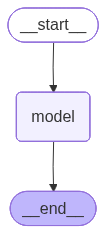

In [10]:
display(
    Image(graph.get_graph().draw_mermaid_png())
)

In [ ]:
from pathlib import Path

base_dir = Path(".")
input_dir = base_dir.joinpath("LARGE_CLIENT")
output_dir = base_dir.joinpath("OUTPUT")
output_dir.mkdir(parents=True, exist_ok=True)

total = 0
for subdir in sorted([p for p in input_dir.rglob("*") if p.is_dir()]):
    current_output_dir = output_dir.joinpath(subdir)
    current_output_dir.mkdir(parents=True, exist_ok=True)
    for file_path in sorted([p for p in subdir.iterdir() if p.is_file()]):
        content = file_path.read_text(encoding="utf-8", errors="replace")
        output_file_name = current_output_dir.joinpath(file_path.name)
        if content.find("PRIMARY KEY CLUSTERED ([Id] ASC)") != -1:  # skip empty PK clustered indexes on ID column
            continue
        result = graph.invoke(input={"question": content})
        total += 1
        print(str(total) + " : " + result['response'])
        with open(output_file_name, 'w') as output:
            output.write(result['response'])
print(f"TOTAL: {total}")
